In [1]:
import zipfile
zipfile.ZipFile('img_color_data.zip','r').extractall('')

In [1]:
from numpy import zeros, ones, asarray, load, vstack, savez_compressed
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras import Input
from keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Activation, Concatenate, Dropout, BatchNormalization
from matplotlib import pyplot as plt
from os import listdir
from keras.preprocessing.image import ImageDataGenerator
from skimage.color import rgb2lab
import numpy as np

In [2]:
def disc(img_shape):
  init=RandomNormal(stddev=0.02)
  in_src_img=Input(shape=img_shape)
  in_tar_img=Input(shape=img_shape)
  merged=Concatenate()([in_src_img,in_tar_img])
  d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
  d = LeakyReLU(alpha=0.2)(d)
  d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
  patch_out = Activation('sigmoid')(d)
  model = Model([in_src_img, in_tar_img], patch_out)
  opt = Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
  return model

In [3]:
def enc(layer_in,n_filters,batchnorm=True):
    init = RandomNormal(stddev=0.02)
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    g = LeakyReLU(alpha=0.2)(g)
    return g

def dec(layer_in,skip_in,n_filters,dropout=True):
    init = RandomNormal(stddev=0.02)
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    g = BatchNormalization()(g, training=True)
    if dropout:
        g = Dropout(0.5)(g, training=True)
    g = Concatenate()([g, skip_in])
    g = Activation('relu')(g)
    return g

def gen(img_shape=(256,256,3)):
    init = RandomNormal(stddev=0.02)
    in_image = Input(shape=img_shape)
    e1 = enc(in_image, 64, batchnorm=False)
    e2 = enc(e1, 128)
    e3 = enc(e2, 256)
    e4 = enc(e3, 512)
    e5 = enc(e4, 512)
    e6 = enc(e5, 512)
    e7 = enc(e6, 512)
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
    b = Activation('relu')(b)
    d1 = dec(b, e7, 512)
    d2 = dec(d1, e6, 512)
    d3 = dec(d2, e5, 512)
    d4 = dec(d3, e4, 512, dropout=False)
    d5 = dec(d4, e3, 256, dropout=False)
    d6 = dec(d5, e2, 128, dropout=False)
    d7 = dec(d6, e1, 64, dropout=False)
    g = Conv2DTranspose(img_shape[2], (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
    out_image = Activation('tanh')(g)
    model = Model(in_image, out_image)
    return model

In [4]:
def gan(g_model,d_model,img_shape):
  for layer in d_model.layers:
    if not isinstance(layer,BatchNormalization):
      layer.trainable=False
  in_src=Input(shape=img_shape)
  gen_out=g_model(in_src)
  dis_out=d_model([in_src,gen_out])
  model=Model(in_src,[dis_out,gen_out])
  opt=Adam(learning_rate=0.0002,beta_1=0.5,beta_2=0.999)
  model.compile(loss=['binary_crossentropy','mae'],optimizer=opt,loss_weights=[1,100])
  return model

In [5]:
def gen_real_samp(dataset,n_samples,patch_shape):
  trainA,trainB=dataset
  ix=randint(0,trainA.shape[0],n_samples)
  X1,X2=trainA[ix],trainB[ix]
  y=ones((n_samples,patch_shape,patch_shape,1))
  return [X1,X2],y

def gen_fake_samp(g_model,samples,patch_shape):
  X=g_model.predict(samples)
  y=zeros((len(X),patch_shape,patch_shape,1))
  return X,y

In [6]:
def perf(step,g_model,dataset,n_samples=3):
  [X_realA,X_realB],_=gen_real_samp(dataset,n_samples,1)
  X_fakeB,_=gen_fake_samp(g_model,X_realA,1)
  X_realA=(X_realA+1)/2
  X_realB=(X_realB+1)/2
  X_fakeB=(X_fakeB+1)/2
  for i in range(n_samples):
    plt.subplot(3, n_samples, 1 + i)
    plt.axis('off')
    plt.imshow(X_realA[i])
  for i in range(n_samples):
    plt.subplot(3, n_samples, 1 + n_samples + i)
    plt.axis('off')
    plt.imshow(X_fakeB[i])
  for i in range(n_samples):
    plt.subplot(3, n_samples, 1 + n_samples*2 + i)
    plt.axis('off')
    plt.imshow(X_realB[i])
  filename1 = 'plot_%06d.png' % (step+1)
  plt.savefig(filename1)
  plt.close()
  filename2 = 'model_%06d.h5' % (step+1)
  g_model.save(filename2)
  print('>Saved: %s and %s' % (filename1, filename2))

In [7]:
def train(d_model,g_model,gan_model,dataset,n_epochs=100,n_batch=1):
  n_patch=d_model.output_shape[1]
  trainA,trainB=dataset
  bat_per_epo=int(len(trainA)/n_batch)
  n_steps=bat_per_epo*n_epochs
  for i in range(n_steps):
    [X_realA,X_realB],y_real=gen_real_samp(dataset,n_batch,n_patch)
    X_fakeB,y_fake=gen_fake_samp(g_model,X_realA,n_patch)
    d_loss1=d_model.train_on_batch([X_realA,X_realB],y_real)
    d_loss2=d_model.train_on_batch([X_realA,X_fakeB],y_fake)
    g_loss,_,_=gan_model.train_on_batch(X_realA,[y_real,X_realB])
    print('>%d,d1[%.3f] d2[%.3f] g[%.3f]'%(i+1,d_loss1,d_loss2,g_loss))
    if (i+1)%(500)==0:
      perf(i,g_model,dataset)

In [8]:
def preprocess_data(data):
  X1,X2=data[0],data[1]
  X1=(X1-0.5)*2
  X2=(X2-0.5)*2
  return [X1,X2]

In [9]:
path='img_color_data'
train_datagen=ImageDataGenerator(rescale=1./255)
Train=train_datagen.flow_from_directory(path,target_size=(256,256),batch_size=2500,class_mode=None)

Found 2791 images belonging to 1 classes.


In [10]:
src_list=list()
tar_list=list()
for img in Train[0]:
    try:
        lab_img=rgb2lab(img)
        lab_img=(lab_img+[0,128,128])/[100,255,255]
        tar_list.append(img)
        src_list.append(lab_img)
    except:
        print('error')
src_imgs=asarray(src_list)
tar_imgs=asarray(tar_list)
img_shape=src_imgs.shape[1:]
d_model=disc(img_shape)
g_model=gen(img_shape)
gan_model=gan(g_model,d_model,img_shape)
data=[src_imgs,tar_imgs]
data=preprocess_data(data)
train(d_model,g_model,gan_model,data,n_epochs=6,n_batch=4)

C:\Users\User\anaconda3\lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


1/1 [==============================] - 2s 2s/step


>1,d1[0.301] d2[0.883] g[42.493]
1/1 [==============================] - 0s 207ms/step
>2,d1[0.550] d2[1.133] g[42.143]
1/1 [==============================] - 0s 222ms/step
>3,d1[0.402] d2[0.983] g[37.164]
1/1 [==============================] - 0s 222ms/step
>4,d1[0.312] d2[0.748] g[36.418]
1/1 [==============================] - 0s 238ms/step
>5,d1[0.286] d2[0.595] g[36.577]
1/1 [==============================] - 0s 290ms/step
>6,d1[0.302] d2[0.492] g[37.568]
1/1 [==============================] - 0s 222ms/step
>7,d1[0.347] d2[0.427] g[22.458]
1/1 [==============================] - 0s 232ms/step
>8,d1[0.354] d2[0.381] g[25.851]
1/1 [==============================] - 0s 205ms/step
>9,d1[0.368] d2[0.378] g[25.427]
1/1 [==============================] - 0s 237ms/step
>10,d1[0.359] d2[0.385] g[20.176]
1/1 [==============================] - 0s 193ms/step
>11,d1[0.374] d2[0.385] g[39.193]
1/1 [==============================] - 0s 221ms/step


C:\Users\User\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


>Saved: plot_000500.png and model_000500.h5
1/1 [==============================] - 0s 205ms/step
>501,d1[0.117] d2[0.196] g[10.422]
1/1 [==============================] - 0s 214ms/step
>502,d1[0.308] d2[0.317] g[9.467]
1/1 [==============================] - 0s 209ms/step
>503,d1[0.130] d2[0.334] g[11.106]
1/1 [==============================] - 0s 220ms/step
>504,d1[0.459] d2[0.331] g[10.111]
1/1 [==============================] - 0s 226ms/step
>505,d1[0.326] d2[0.329] g[12.009]
1/1 [==============================] - 0s 205ms/step
>506,d1[0.334] d2[0.330] g[8.984]
1/1 [==============================] - 0s 206ms/step
>507,d1[0.106] d2[0.266] g[10.564]
1/1 [==============================] - 0s 191ms/step
>508,d1[0.270] d2[0.271] g[9.243]
1/1 [==============================] - 0s 205ms/step
>509,d1[0.209] d2[0.259] g[8.932]
1/1 [==============================] - 0s 206ms/step
>510,d1[0.626] d2[0.220] g[9.778]
1/1 [==============================] - 0s 237ms/step
>511,d1[0.121] d2[0.319] g[9

In [13]:
ix = randint(0, 291, 100)
src_list=list()
tar_list=list()
for i in ix:
    lab_img=rgb2lab(Train[1][i])
    lab_img=(lab_img+[0,128,128])/[100,255,255]
    tar_list.append(Train[1][i])
    src_list.append(lab_img)
src_imgs=asarray(src_list)
tar_imgs=asarray(tar_list)
img_shape=src_imgs.shape[1:]
data=[src_imgs,tar_imgs]
data=preprocess_data(data)

In [19]:
from skimage.metrics import structural_similarity as ssim
from keras.models import load_model
model=load_model('model_003500.h5')
[X1, X2] = data
win_size = 5
accuracies = []
for i in range(100):
    c = list()
    c.append(X1[i])
    src_img = asarray(list(c))
    c = list()
    c.append(X2[i])
    h=asarray(list(c))
    gen_img = model.predict(src_img)
    gen_img = (gen_img + 1) / 2.0
    gt_img = np.resize(gen_img,(255, 255,3))
    rt_img = (h + 1) / 2.0
    rt_img = np.resize(rt_img,(255, 255,3))
    accuracy = ssim(gt_img,rt_img, win_size=win_size, channel_axis=2)
    accuracies.append(accuracy)
average_accuracy = np.mean(accuracies)
print("Average Accuracy:", average_accuracy)

1/1 [==============================] - 0s 117ms/step
Average Accuracy: 0.94949377


In [21]:
def plot_images(src_img, gen_img, tar_img):
    images = vstack((src_img, gen_img, tar_img))
    images = (images + 1) / 2.0
    titles = ['Source', 'Generated', 'Expected']
    for i in range(len(images)):
        plt.subplot(1, 3, 1 + i)
        plt.axis('off')
        plt.imshow(images[i])
        plt.title(titles[i])
    plt.show()

In [30]:
def print_images(src_img, gen_img, tar_img,num):
    images = vstack((src_img, gen_img, tar_img))
    images = (images + 1) / 2.0
    titles = ['Source', 'Generated', 'Expected']
    for i in range(len(images)):
        plt.subplot(1, 3, 1 + i)
        plt.axis('off')
        plt.imshow(images[i])
        plt.title(titles[i])
    filename1 = 'plot_%02d.png' % (num)
    plt.savefig(filename1)

1/1 [==============================] - 0s 140ms/step


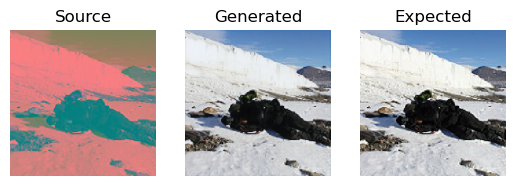

1/1 [==============================] - 0s 115ms/step


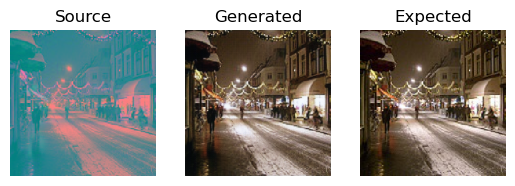

1/1 [==============================] - 0s 121ms/step


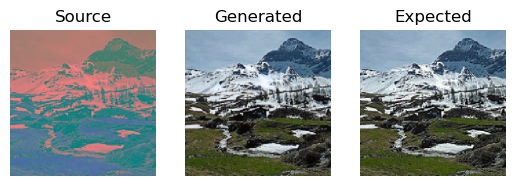

1/1 [==============================] - 0s 133ms/step


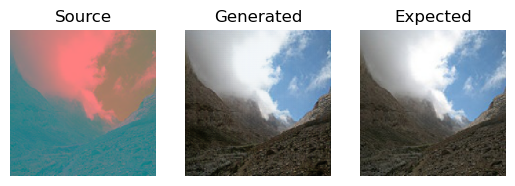

1/1 [==============================] - 0s 113ms/step


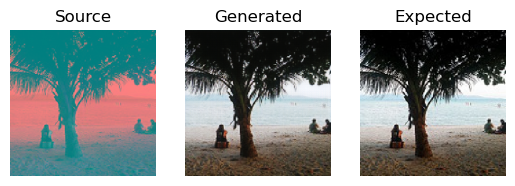

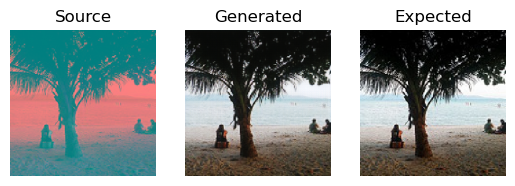

In [31]:
[X1, X2] = data
ix = randint(0, len(X1), 5)
cnt=1
for i in ix:
    c=list()
    c.append(X1[i])
    src_image=asarray(list(c))
    c=list()
    c.append(X2[i])
    tar_image=asarray(list(c))
    gen_image= model.predict(src_image)
    plot_images(src_image, gen_image, tar_image)
    print_images(src_image, gen_image, tar_image,cnt)
    cnt+=1